# Fourier Transform

Useful guide: https://homepages.inf.ed.ac.uk/rbf/HIPR2/fourier.htm

In [1]:
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
import imageio.v3 as iio
import matplotlib.pyplot as plt
from tabulate import tabulate
from skimage.transform import resize

1. Load a grayscale image and apply the 2D Discrete Fourier Transform (DFT) to it. Visualize
the original image and its frequency spectrum (magnitude). Submit the images, and
explanation.

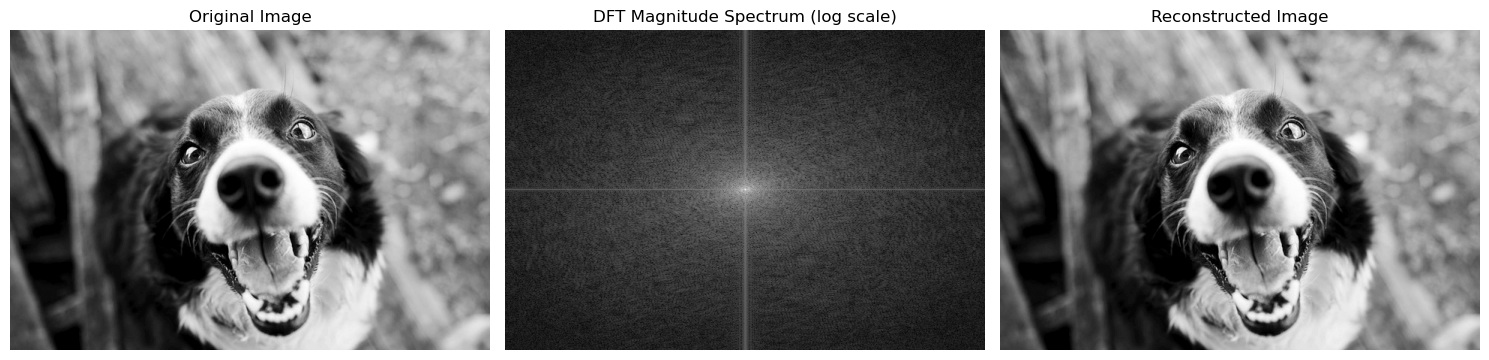

In [2]:
# Load image
img = iio.imread("img/grayscale.png")

# Convert to grayscale if RGB
if img.ndim == 3:
    img = np.dot(img[..., :3], [0.299, 0.587, 0.114])

# Normalize image intensity to [0, 1]
img = img.astype(float)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# Compute 2D DFT and shift zero frequency to center
dft_result = fft2(img)
dft_shifted = fftshift(dft_result)

# Compute magnitude spectrum (for visualization)
magnitude = np.abs(dft_shifted)
magnitude_log = np.log(1 + magnitude)  # log-scale for better visibility

# Reconstruct image from inverse DFT
dft_ishift = ifftshift(dft_shifted)
img_reconstructed = ifft2(dft_ishift)
img_reconstructed = np.abs(img_reconstructed)

# Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(magnitude_log, cmap='gray')
plt.title("DFT Magnitude Spectrum (log scale)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_reconstructed, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

plt.tight_layout()
plt.show()

The 2D Discrete Fourier Transform (DFT) expresses a grayscale image as a sum of oriented 2D sinusoids, moving from the spatial domain (pixel intensities) to the frequency domain, where each point encodes a spatial frequency and direction. In the shown result, the log-magnitude spectrum has a bright center, indicating strong low-frequency energy that captures broad, smooth intensity variations (the dog’s overall shape), while the darker outer regions correspond to weaker high-frequency content (fine texture and noise). The faint vertical and horizontal streaks reveal dominant structures aligned with those axes. Taking the inverse DFT of the full complex spectrum reconstructs an image that matches the original, demonstrating that the transform is inherently lossless aside from tiny numerical errors.

2. Implement a low-pass filter in the frequency domain to remove high-frequency noise from
an image. Compare the filtered image with the original image. Submit images, and analysis
of the results.

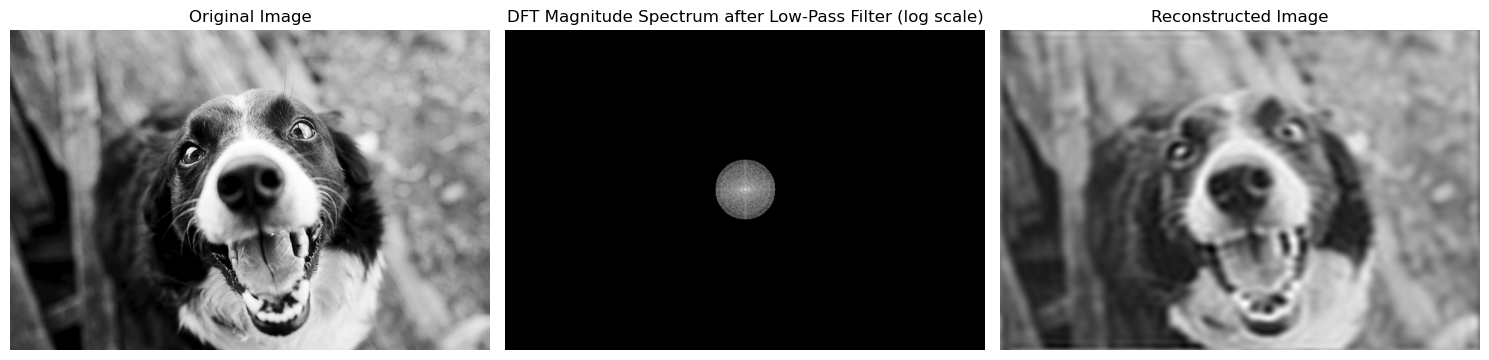

In [3]:
# Load image
img = iio.imread("img/grayscale.png")
if img.ndim == 3:
    img = np.dot(img[..., :3], [0.299, 0.587, 0.114])

# Normalize image intensity to [0, 1]
img = img.astype(float)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# Compute 2D DFT and shift zero frequency to center
F = fft2(img)
Fshift = fftshift(F)

# Create a high-pass filter mask (1 outside circle, 0 inside)
M, N = img.shape
cy, cx = M // 2, N // 2
Y, X = np.ogrid[:M, :N]
radius = int(0.08 * min(M, N))     # tweak radius
mask = ((X - cx)**2 + (Y - cy)**2 <= radius**2).astype(float)  # 1 inside circle, 0 outside
r2 = max(radius + 6, radius + radius//6)
mask_soft = ((X - cx)**2 + (Y - cy)**2 <= r2**2).astype(float)
H = 0.5*mask + 0.5*mask_soft       # soft LP mask in [0,1]

# Apply high-pass filter in frequency domain
Gshift = Fshift * H

# Reconstruct image from filtered DFT
g = ifft2(ifftshift(Gshift))
g = np.real(g)
g = (g - g.min()) / (g.max() - g.min() + 1e-12)

# Compute magnitude spectrum after filtering 
spec_log = np.log1p(np.abs(Gshift))
spec_log = (spec_log - spec_log.min()) / (spec_log.max() - spec_log.min() + 1e-12)

# Visualize results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original Image"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(spec_log, cmap='gray'); plt.title("DFT Magnitude Spectrum after Low-Pass Filter (log scale)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(g, cmap='gray'); plt.title("Reconstructed Image"); plt.axis('off')
plt.tight_layout(); plt.show()


In the DFT, the low-pass filter keeps low frequencies (center of the spectrum) and removes high frequencies (edges) by applying a circular mask. This suppresses fine details and noise while preserving overall structure. As a result, the reconstructed image appears smoother and slightly blurred compared to the original. The bright center in the filtered spectrum confirms that only low frequencies remain.

3. Implement a high-pass filter to enhance the edges in an image. Visualize the filtered image
and discuss the effects observed. Submit images, and explanation.

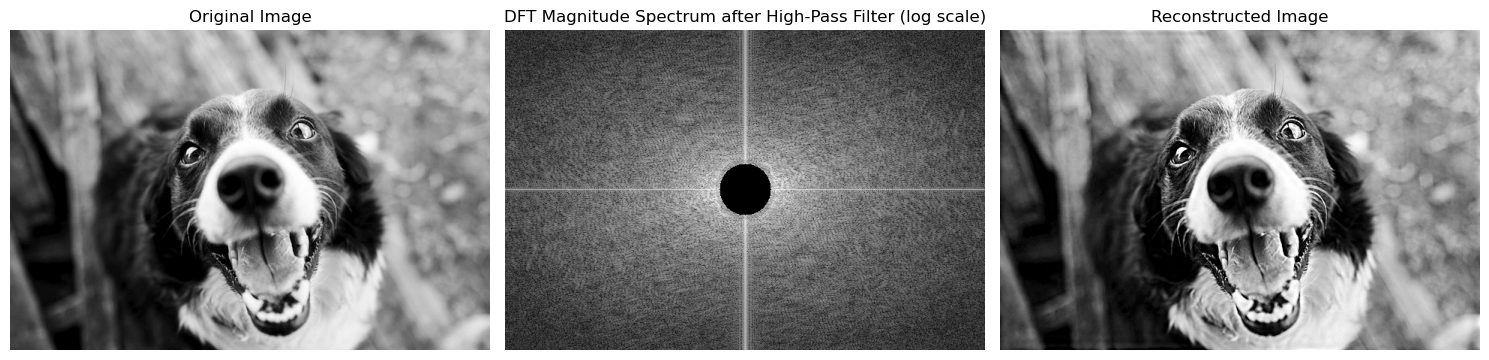

In [4]:
# Load image
img = iio.imread("img/grayscale.png")
if img.ndim == 3:
    img = np.dot(img[..., :3], [0.299, 0.587, 0.114])

# Normalize image intensity to [0, 1]
img = img.astype(float)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# Compute 2D DFT and shift zero frequency to center
F = fft2(img)
Fshift = fftshift(F)

# Create a high-pass filter mask (1 outside circle, 0 inside)
M, N = img.shape
cy, cx = M // 2, N // 2
Y, X = np.ogrid[:M, :N]
radius = int(0.08 * min(M, N))
lp_core = ((X - cx)**2 + (Y - cy)**2 <= radius**2).astype(float)
r2 = max(radius + 6, radius + radius//6)
lp_soft = ((X - cx)**2 + (Y - cy)**2 <= r2**2).astype(float)
H_lp = 0.5*lp_core + 0.5*lp_soft
H_hp = 1.0 - H_lp

# Apply high-pass filter in frequency domain
Gshift = Fshift * H_hp

# IDFT of HP (edges)
g_hp = np.real(ifft2(ifftshift(Gshift)))

# High-boost (edge enhancement)
alpha = 0.6  
sharp = img + alpha * (g_hp - g_hp.mean())
sharp = np.clip(sharp, 0, 1)

# Compute magnitude spectrum after filtering
spec_log = np.log1p(np.abs(Gshift))
spec_log = (spec_log - spec_log.min()) / (spec_log.max() - spec_log.min() + 1e-12)

# Visualize results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original Image"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(spec_log, cmap='gray'); plt.title("DFT Magnitude Spectrum after High-Pass Filter (log scale)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(sharp, cmap='gray'); plt.title("Reconstructed Image"); plt.axis('off')
plt.tight_layout(); plt.show()


In the DFT, the high-pass filter removes low frequencies (center of the spectrum) and keeps high frequencies (edges of the spectrum) using a circular mask. This highlights edges and fine details while reducing smooth areas and lighting variations. The dark center in the filtered spectrum shows that low frequencies were suppressed. The reconstructed image appears sharper with enhanced edges, though some noise and slight ringing may occur.

4. Implement an image compression technique using Fourier Transform by selectively keeping
only a certain percentage of the Fourier coefficients. Evaluate the quality of the
reconstructed image as you vary the percentage of coefficients used. Submit the images,
and your observations on image quality and compression ratio.

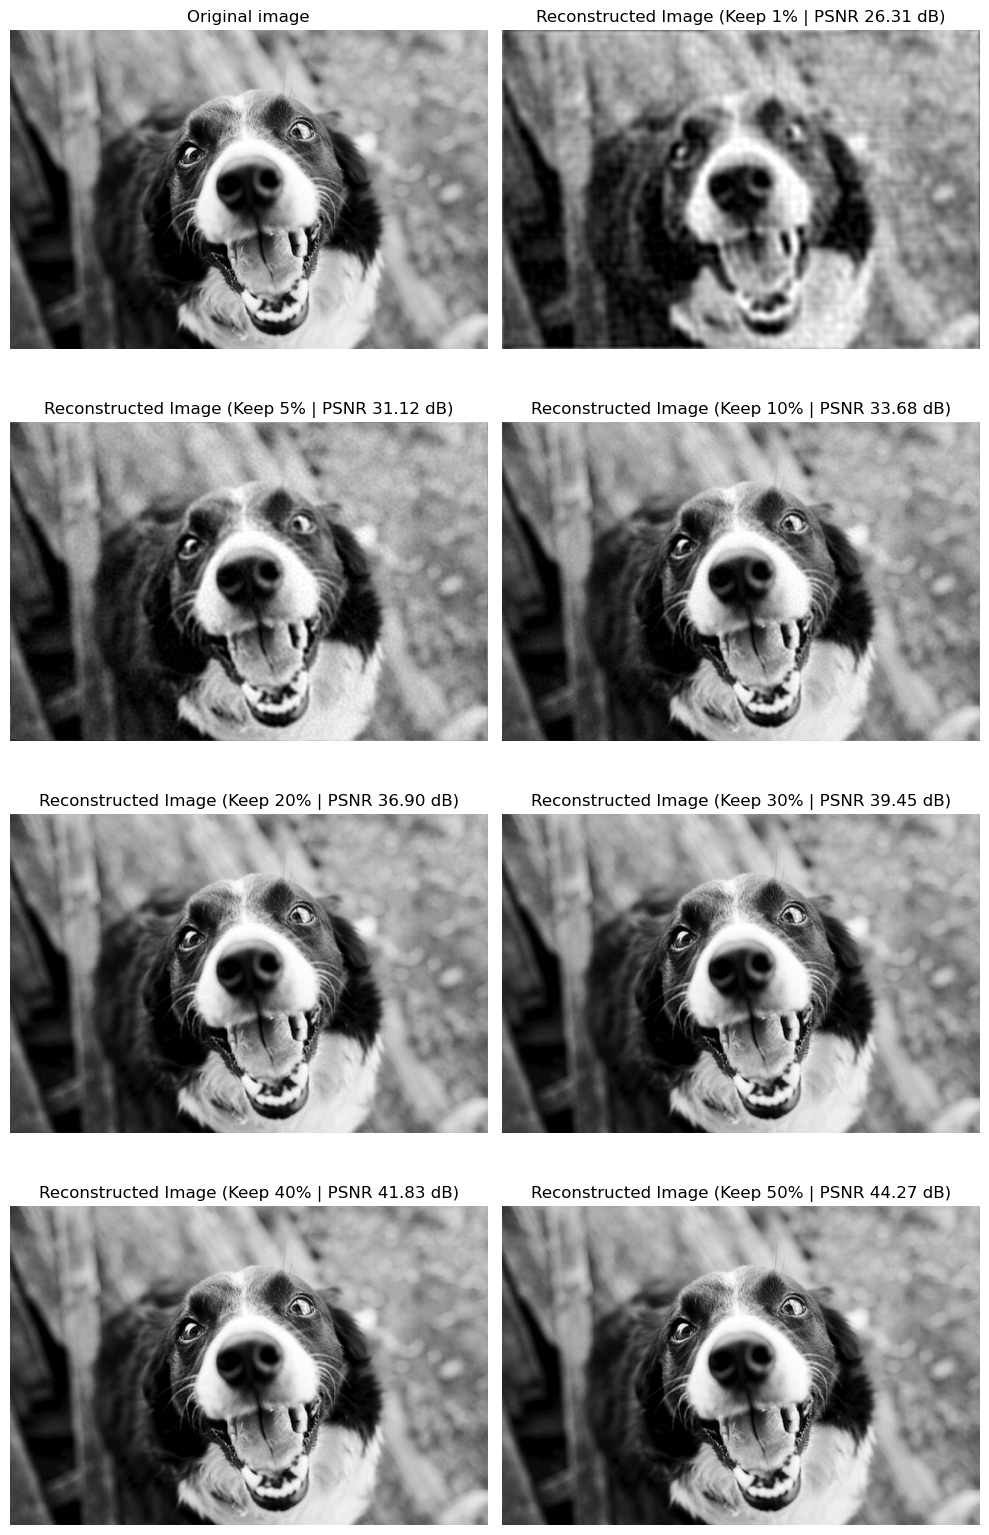

| % Coefficients Kept   | Kept/Total (%)   | PSNR (dB)   |
|-----------------------|------------------|-------------|
| 1%                    | 1.00%            | 26.31 dB    |
| 5%                    | 5.00%            | 31.12 dB    |
| 10%                   | 10.00%           | 33.68 dB    |
| 20%                   | 20.00%           | 36.90 dB    |
| 30%                   | 30.00%           | 39.45 dB    |
| 40%                   | 40.00%           | 41.83 dB    |
| 50%                   | 50.00%           | 44.27 dB    |


In [5]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2
from tabulate import tabulate
import math

# Load image
img = iio.imread("img/grayscale.png")

# Convert to grayscale if RGB
if img.ndim == 3:
    img = img[..., :3]
    img = np.dot(img, [0.299, 0.587, 0.114])

# Normalize image intensity to [0, 1]
img = img.astype(float)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# Compute 2D DFT
F = fft2(img)
mag = np.abs(F)
total = mag.size

def keep_top_percent(F, pct):
    """Keep the top 'pct' percent of Fourier coefficients by magnitude."""
    if pct >= 100:
        mask = np.ones_like(F, dtype=bool)
        kept = total
    else:
        k = max(1, int(np.ceil(total * pct / 100.0)))
        thresh = np.partition(mag.ravel(), total - k)[total - k]  # kth largest threshold
        mask = (mag >= thresh)
        kept = int(mask.sum())
    Fc = F * mask
    rec = np.real(ifft2(Fc))
    rec = np.clip(rec, 0, 1)
    return rec, mask, kept

def psnr(x, y):
    """PSNR for images in [0,1]."""
    mse = np.mean((x - y) ** 2)
    if mse <= 1e-12:  # identical
        return 99.0
    return 10 * np.log10(1.0 / mse)

# Test several percentages
percents = [1, 5, 10, 20, 30, 40, 50]
results = []
for p in percents:
    rec, mask, kept = keep_top_percent(F, p)
    results.append({
        "pct": p,
        "rec": rec,
        "kept": kept,
        "cr": kept / total,            
        "PSNR": psnr(img, rec),
    })

# ---- Plot original and reconstructions (2 per row) ----
nplots = len(percents) + 1  # original + reconstructions
cols = 2
rows = math.ceil(nplots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(10, 4 * rows))
axes = axes.ravel()

# Original image
axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original image")
axes[0].axis('off')

# Reconstructed images
for i, r in enumerate(results, start=1):
    axes[i].imshow(r["rec"], cmap='gray')
    axes[i].set_title(f"Reconstructed Image (Keep {r['pct']}% | PSNR {r['PSNR']:.2f} dB)")
    axes[i].axis('off')

# Hide unused subplots
for j in range(len(results) + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# ---- Print results table ----
table_data = [
    [f"{r['pct']}%", f"{r['cr']*100:.2f}%", f"{r['PSNR']:.2f} dB"]
    for r in results
]
headers = ["% Coefficients Kept", "Kept/Total (%)", "PSNR (dB)"]
print(tabulate(table_data, headers=headers, tablefmt="github"))

As the proportion of retained Fourier coefficients increases, the reconstructed image quality improves gradually. When keeping only 1–5% of the coefficients, the image remains recognizable but appears blurred and lacks detail. At 10–20%, most structures and textures are restored, showing a noticeable enhancement in visual quality. From 30–50%, the reconstruction becomes nearly indistinguishable from the original, with PSNR values exceeding 40 dB. These results demonstrate that the essential visual information is concentrated in a small fraction of large-magnitude Fourier coefficients, enabling strong compression with minimal perceptual loss — effectively balancing compression ratio and image fidelity.

# PCA

Select a set of grayscale images (e.g., faces, landscapes, or any other category).
Normalize the images by scaling pixel values to a range [0, 1].

In [6]:
# List of image paths
image_paths = [
    "img/grayscale.png",
    "img/grayscale1.png",
    "img/grayscale2.png",
    "img/grayscale3.png"
]

# Choose a common target size (e.g., 128×128)
target_size = (128, 128)

# Load, convert to grayscale, normalize, and resize
orgiginal_images = []
for path in image_paths:
    img = iio.imread(path).astype(float)

    # Convert to grayscale if RGB or RGBA
    if img.ndim == 3:
        img = img[..., :3]
        img = np.dot(img, [0.299, 0.587, 0.114])

    # Normalize pixel values to [0, 1]
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # Resize to the target size (values remain in [0, 1])
    img = resize(img, target_size, anti_aliasing=True)

    orgiginal_images.append(img)

# Stack into a single 3D array for PCA
original_images = np.stack(orgiginal_images, axis=0)
print("Loaded, resized, and normalized images:", original_images.shape)


Loaded, resized, and normalized images: (4, 128, 128)


## PCA Implementation:
Write a Python function to perform PCA on the images.
Implement the following steps:

1. Convert the image into a 2D matrix where each row represents an image and each column
represents a pixel value

2. Compute the covariance matrix of the image data.

3. Calculate the eigenvalues and eigenvectors of the covariance matrix.

4. Sort the eigenvectors based on the eigenvalues in descending order.


5. Select the top k eigenvectors to form the principal components.

6. Project the original images onto the lower-dimensional subspace defined by the selected principal components.

In [7]:
def pca_images(images, k):
    # 1) Rows=images, Cols=pixels
    if images.ndim == 3:
        n_images, H, W = images.shape
        X = images.reshape(n_images, H * W)
    elif images.ndim == 2:
        X = images
        n_images, _ = X.shape
        H = W = None
    else:
        raise ValueError("`images` must be (n_images, H, W) or (n_images, n_pixels).")
    if n_images < 2:
        raise ValueError("PCA requires at least 2 images.")

    # Use float32 to save memory; PCA quality is fine for images
    X = X.astype(np.float32, copy=False)

    # Mean-center
    mean_vec = X.mean(axis=0, dtype=np.float32)
    Xc = X - mean_vec

    # SVD on centered data: Xc = U S Vt
    # full_matrices=False gives U:(n_images,r), S:(r,), Vt:(r,n_pixels) with r=min(n_images, n_pixels)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)

    # Eigenvalues of covariance = S^2 / (n_images - 1)
    evals = (S ** 2) / (n_images - 1)

    # Components are columns of V = Vt.T
    V = Vt.T

    # You can’t have more meaningful components than rank
    r = V.shape[1]
    k_eff = min(k, r)
    components = V[:, :k_eff]
    eigenvalues = evals[:k_eff]

    # Project data
    Z = Xc @ components

    return Z, components, eigenvalues, mean_vec


## Reconstruction of Images:

1. Using the selected principal components, reconstruct the images.

In [8]:
def reconstruct_from_pca(Z, components, mean_vec, original_shape):
    """Reconstruct images from PCA representation"""
    n_images, H, W = original_shape
    X_hat = Z @ components.T + mean_vec  # (n_images, n_pixels)
    X_hat = X_hat.reshape(n_images, H, W)
    return np.clip(X_hat, 0.0, 1.0)

2. Compare the reconstructed images with the original images to observe the effects of
dimensionality reduction.

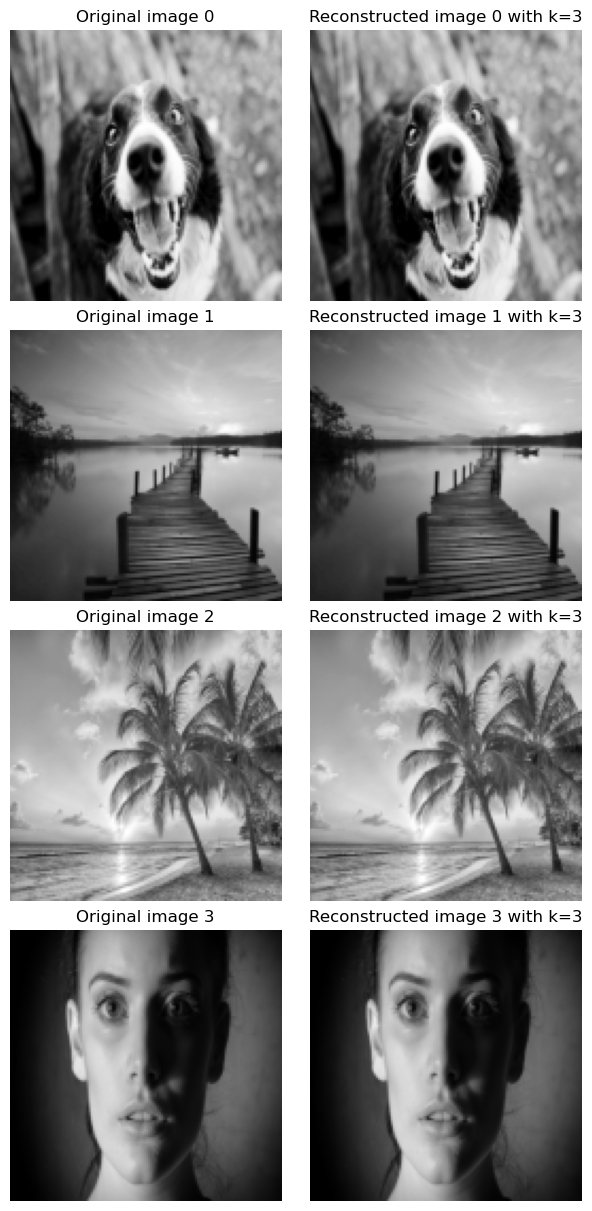

In [9]:
# Define number of principal components
k = 3

# Perform PCA on images to get Z, components, eigenvalues, mean_vec
Z, components, eigenvalues, mean_vec = pca_images(original_images, k)

# Reconstruct images using PCA outputs
n_images, H, W = original_images.shape
reconstructed_images = reconstruct_from_pca(Z, components, mean_vec, (n_images, H, W))

rows = n_images
fig, axes = plt.subplots(rows, 2, figsize=(6, 3 * rows), constrained_layout=True)

if rows == 1:
    axes = np.array([axes])  # ensure 2D indexing

# Plot original and reconstructed images side by side
for i in range(n_images):
    # Original
    ax = axes[i, 0]
    ax.imshow(original_images[i], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Original image {i}")
    ax.axis('off')

    # Reconstructed
    ax = axes[i, 1]
    ax.imshow(reconstructed_images[i], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Reconstructed image {i} with k={k}")
    ax.axis('off')

plt.show()

## Experimentation:

1. Vary the number of principal components (k) and observe the impact on the quality of the
reconstructed images.

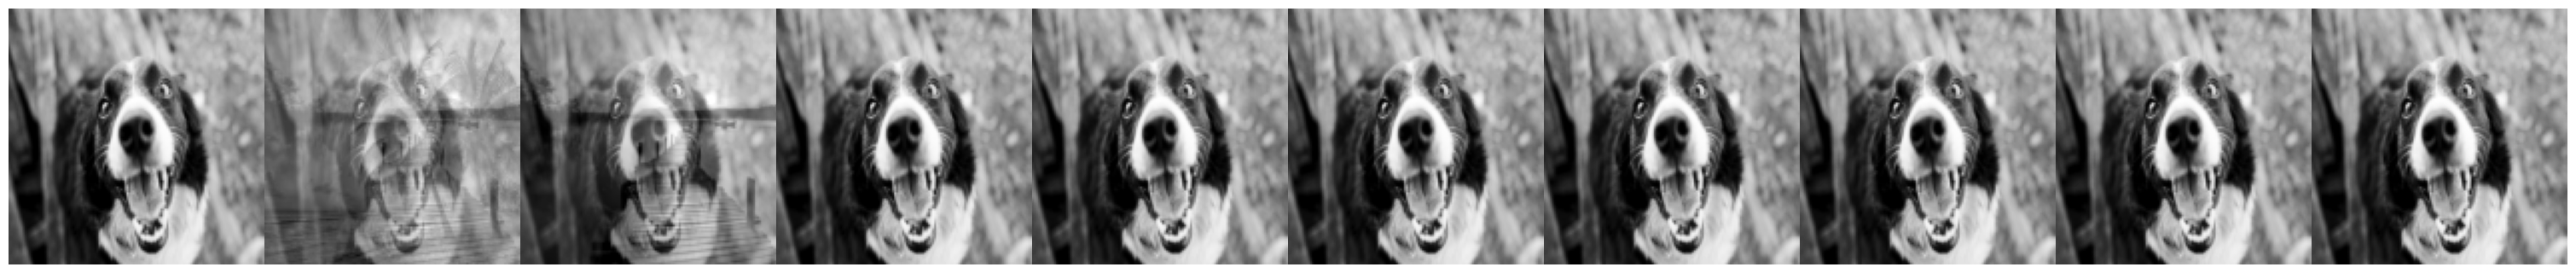

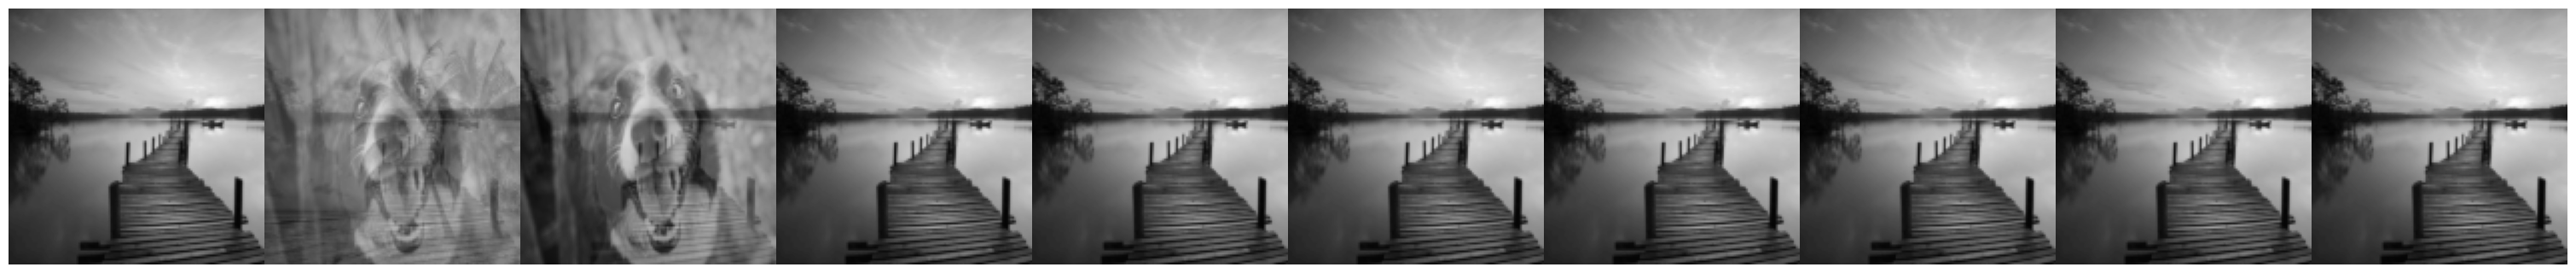

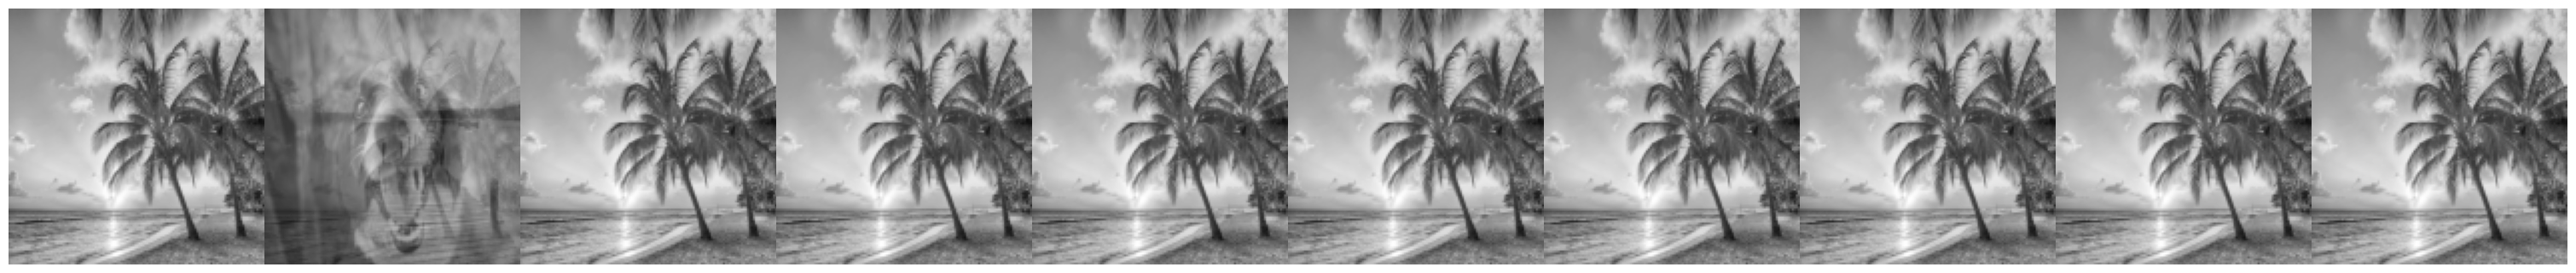

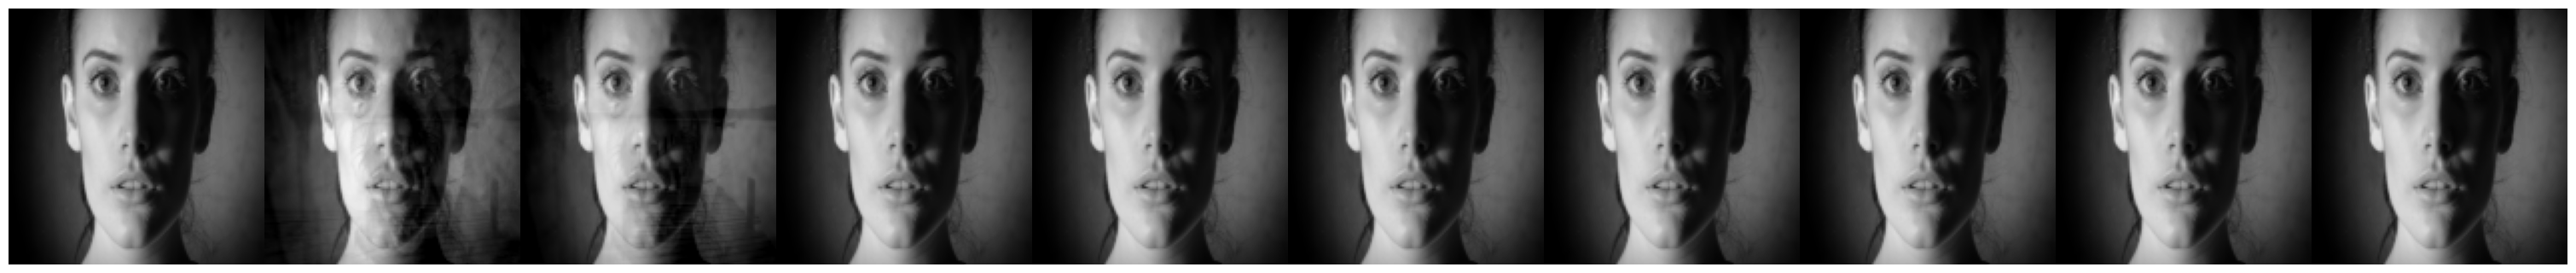

In [10]:
# Cell — One figure per image, showing only images (original + reconstructions for each k)

import numpy as np
import matplotlib.pyplot as plt

def mse_per_image(orig, recon):
    diff = orig - recon
    return (diff ** 2).reshape(len(orig), -1).mean(axis=1)

def psnr_from_mse(mse, data_range=1.0):
    with np.errstate(divide='ignore'):
        psnr = 10.0 * np.log10((data_range ** 2) / mse)
    psnr[np.isinf(psnr)] = 100.0
    return psnr

# Choose k values to test
ks = [1, 2, 3, 5, 10, 20, 30, 40, 50]
n_images, H, W = original_images.shape
ks = [k for k in ks if k <= H * W]
max_k = max(ks)

# Fit PCA once with the largest k
Z_max, components_max, eigenvalues_max, mean_vec = pca_images(original_images, max_k)
X2d = original_images.reshape(n_images, -1)

# Precompute reconstructions for each k (to reuse below)
recon_by_k = {}
for k in ks:
    comps_k = components_max[:, :k]
    Z_k = (X2d - mean_vec) @ comps_k
    recon_k = reconstruct_from_pca(Z_k, comps_k, mean_vec, (n_images, H, W))
    recon_by_k[k] = recon_k

# Create ONE FIGURE PER IMAGE with only the images (no titles/axes)
for i in range(n_images):
    cols = 1 + len(ks)
    fig, axes = plt.subplots(1, cols, figsize=(3 * cols, 3), constrained_layout=False)
    if cols == 1:
        axes = np.array([axes])

    # Original (first column)
    axes[0].imshow(original_images[i], cmap='gray', vmin=0, vmax=1)
    axes[0].axis('off')

    # Reconstructions for each k (remaining columns)
    for j, k in enumerate(ks, start=1):
        axes[j].imshow(recon_by_k[k][i], cmap='gray', vmin=0, vmax=1)
        axes[j].axis('off')

    # Remove all padding/margins so the figure contains only images
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.show()



2. Plot the variance explained by the principal components and determine the optimal number
of components that balances compression and quality.

## Visual Analysis:

1. Display the original images alongside the reconstructed images for different values of k.

2. Comment on the visual quality of the images and how much information is lost during
compression.

## Error Analysis:

1. Compute the Mean Squared Error (MSE) between the original and reconstructed images.

2. Analyze the trade-off between compression and reconstruction error.

# Image processing

## HOG Features

1. Write a Python script to compute the HOG features of a given image using a library such as
OpenCV or scikit-image.

2. Apply your implementation to at least three different images, including both simple and
complex scenes.

3. Visualize the original image, the gradient image, and the HOG feature image.

4. Compare the HOG features extracted from different images. Discuss the impact of varying
parameters like cell size, block size, and the number of bins on the resulting HOG
descriptors.

## Local Binary Patterns (LBP)

1. Write a Python function to compute the LBP of a given grayscale image. Use the basic 8-
neighbor LBP method.

2. Your function should output the LBP image, where each pixel is replaced by its
corresponding LBP value.

3. Write a Python function to compute the histogram of the LBP image.

4. Plot the histogram and explain what it represents in terms of the texture features of the
image.

5. Apply your LBP function to at least three different grayscale images (e.g., a natural scene, a
texture, and a face image).

6. Generate and compare the histograms of the LBP images.

7. Discuss the differences in the histograms and what they tell you about the textures of the
different images.

## Implement a blob detection algorithm

1. Apply the blob detection algorithm to one of the provided image datasets on blackborad.

2. Visualize the detected blobs on the original images, marking each detected blob with a
circle or bounding box.

3. Calculate and display relevant statistics for each image, such as the number of blobs
detected, their sizes, and positions.

4. Evaluate and discuss the effect of different parameters in the algorithms on the detection of
different blobs.

## Implement a contour detection algorithm.

1. Apply the contour detection algorithm to the same image dataset.

2. Visualize the detected contours on the original images, marking each contour with a
different color.

3. Calculate and display relevant statistics for each image, such as the number of contours
detected, contour area, and perimeter.

4. Compare the results of blob detection and contour detection for the chosen dataset.

5. Discuss the advantages and limitations of each technique.





6. Analyze the impact of different parameters (e.g., threshold values, filter sizes) on the
detection results.

7. Provide examples where one technique might be more suitable than the other.